In [11]:
import sys
sys.path.append('../')
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from dft_descriptors.prepocessing import preprocess
from classic_descriptors.featurisation import one_hot_encoding
from classic_descriptors.featurisation import process_yield
from sklearn.decomposition import PCA

In [12]:
# data-set downloaded from 10.1126/science.aar5169
df_hte = pd.read_csv("BH_HTE_scaled_3.csv")

In [13]:
# scope-like descriptors of maximum increase in mean square error 
# (ref : fig S23 10.1126/science.aar5169)
L_scope_reduced = [
 'aryl_halide_.C3_NMR_shift',
 'aryl_halide_.H2_electrostatic_charge',
 'aryl_halide_V2_frequency']

In [14]:
# optimization-like descriptors of maximum increase in mean square error 
# (ref : fig S23 10.1126/science.aar5169)
L_opt_reduced = ['additive_.C3_NMR_shift',
         'additive_E_LUMO',
         'additive_.O1_electrostatic_charge',
         'additive_.C5_electrostatic_charge',
         'additive_dipole_moment',
         'additive_molecular_volume',
         'base_electronegativity',
         'additive_E_HOMO',
         'additive_V1_intensity',
         'additive_.C4_NMR_shift',
         'additive_V1_frequency',
         'additive_surface_area',
         'additive_.C4_electrostatic_charge',
         'additive_.C3_electrostatic_charge',
         'additive_.N1_electrostatic_charge',
         'base_.N1_electrostatic_charge',
         'base_E_HOMO',
         'base_molecular_weight',
         'additive_ovality',
         'additive_hardness',
         'base_dipole_moment',
         'base_molecular_volume',
         'base_E_LUMO']

In [15]:
from dft_descriptors.featurisation import process_dataframe_dft

# load NiCOlit dataset
df = pd.read_csv("data_csv/Data_test11262021.csv")

# preprocessing and dft-featurization
def AL_preprocess(df):
    df["Lewis Acid"] = df["Lewis Acid"].fillna('NoLewisAcid')
    df["Lewis Acid"] = df["Lewis Acid"].replace('nan', 'NoLewisAcid')
    Lewis_Acids_to_drop = ['O=C(O[Cs])O[Cs]', 'Cl[Cs]', 
                       'O=S(=O)(O[Sc](OS(=O)(=O)C(F)(F)F)OS(=O)(=O)C(F)(F)F)C(F)(F)F', 
                       'F[Cs]', 'O=P(O[Na])(O[Na])O[Na]', '[Rb+]',
                       'CC(C)(C)C(=O)O[Cs]', '[Cs+]', 'CC(=O)O[Cu]OC(C)=O', 'F[Sr]F']
    for al in Lewis_Acids_to_drop:
        df = df[df["Lewis Acid"] != al]  
    return df.reset_index(drop=True)

# Creating dataframe for NiCOlit projection on scope and optimisation
df_lit = preprocess(df)
df_lit = AL_preprocess(df_lit)
X, y, DOIs, Mecas, Origin, (v_scope, v_optim) = process_dataframe_dft(df_lit, data_path='data_csv/', dim=True)
scope = np.array(v_scope)
optim = np.array(v_optim)

# the first 134 dimension corresponds to the scope dimension
X_sco = X[:, :np.sum(v_scope)]
# the other dimension corresponds to the optimization dimension
X_opt = X[:, np.sum(v_scope):]


# Projection on PCA 1 of scope and optimization
pca = PCA(n_components=2)
pca.fit(X_sco)
X_sco_pc1 = pca.transform(X_sco)
sco_pc1 = np.array([i[0] for i in X_sco_pc1])

pca2 = PCA(n_components=2)
pca2.fit(X_opt)
X_opt_pc1 = pca2.transform(X_opt)
opt_pc1 = np.array([i[1] for i in X_opt_pc1])

df_lit["proj_scope"] = sco_pc1
df_lit["proj_optimisation"] = opt_pc1
df_lit["yield"] = y
df_lit["data type"] = Origin

# Selecting one publication for the plot
doi_num = 13
dois = df_lit["DOI"].unique()
data_doi = df_lit[df_lit["DOI"] == dois[doi_num]]

NoLigand


In [16]:
# Creating dataframe for HTE-Buchwald Hartwig  
# with projections on scope and optimisation
df_hte_sco = df_hte[L_scope_reduced]
df_hte_opt = df_hte[L_opt_reduced]
X_sco = df_hte_sco.values
X_opt = df_hte_opt.values
pca = PCA(n_components=2)
pca2 = PCA(n_components=2)
pca.fit(X_sco)
X_sco_pc1 = pca.transform(X_sco)
sco_pc1 = np.array([i[0] for i in X_sco_pc1])

pca2.fit(X_opt)
X_opt_pc1 = pca2.transform(X_opt)
opt_pc1 = np.array([i[1] for i in X_opt_pc1])

data_hte = pd.DataFrame(data=opt_pc1.reshape(-1,1), columns=["opt"])
data_hte["sco"] = sco_pc1.reshape(-1,1)
data_hte["yield"] = df_hte["yield"]

ValueError: Palette {} not understood

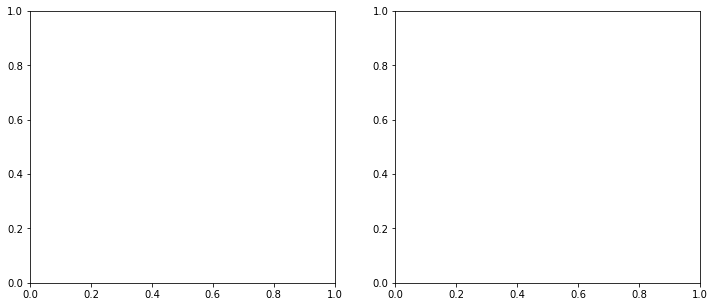

In [17]:
# Main plot
fig, ax = plt.subplots(1,2, figsize=(12, 5))

# plot for the Buchwald-Hartwig dataset
sns.scatterplot(x='opt', y='sco', hue='yield', data=data_hte, marker="s",
                legend="auto", ax = ax[0], palette='flare')

ax[0].set_title("Buchwald Hartwig HTE dataset")
ax[0].legend(title="Yield (%)", loc = 'upper right')
ax[0].set_xlabel("Projection on PC_2 of optimisation subspace")
ax[0].set_ylabel("Projection on PC_1 of scope subspace")
ax[0].set_xticks([])
ax[0].set_yticks([])
handles0 = ax[0].get_legend_handles_labels()

# plot for the NiCOlit dataset
sns.scatterplot(data=data_doi, x='proj_scope', y='proj_optimisation', 
                hue='yield', ax = ax[1], style="data type", legend="auto",
                palette='flare')
ax[1].set_title("Unique Publication Chemical Space")
ax[1].set_xlabel("Projection on PC_1 of optimisation subspace")
ax[1].set_ylabel("Projection on PC_1 of scope subspace")
ax[1].set_xticks([])
ax[1].set_yticks([])

handles = ax[1].get_legend_handles_labels()
h0 = handles[0] 
h0.append(handles[0][0])
h0.append(handles[0][0])
h1 = ['Yield (%)', '15', '30', '45', '60', '75', 'data type', 'optimisation', 'scope', '', '']
ax[1].get_legend().remove()
ax[1].legend(h0, h1, ncol=2, loc='upper right')

plt.savefig('projection_opt-sco_HTE_vs_DOI.svg', dpi=300, format='svg',
        bbox_inches='tight' )